# 🎯 **Goals of the Notebook**  

This notebook aims to **reproduce the results** of the paper  
📖 *Explainable AI for Trees: From Local Explanations to Global Understanding* by **S.L. Lundberg et al. (2019)**.  

It leverages some code from [this repository](https://github.com/suinleelab/treeexplainer-study) and focuses **exclusively** on the **NHANES I dataset**, which is one of the three datasets used in the original study.  

---

## **Outline**  

🔹 **1. Data Loading** – Load the dataset following the original approach.  
🔹 **2. Problem Exploration** – Understand key features and distributions.  
🔹 **3. Model Training** – Train:  
   - 🌳 an **XGBoost model**  
   - 📉 a **linear model**  
   *(Hyperparameter tuning via **RandomSearch**)*
   
🔹 **4. Algorithm Implementation** – Code Algorithm 1 (Explainer) **from scratch**.  
🔹 **5. SHAP Comparison** – Compare our implementation with `TreeExplainer` from the **SHAP** library.  
🔹 **6. Complexity Analysis** – Evaluate **computational efficiency**.  
🔹 **7. Dependence Plots** – Analyze **feature dependencies & interactions**.  
🔹 **8. Global vs. Local SHAP** – Compare **SHAP values** with the **Gain method**.  

---

**G. Vindry & C. Pernot**


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import xgboost as xgb
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import sklearn
from tqdm import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from sklearn.linear_model import LogisticRegression
import time


In [2]:
import os 
print(os.getcwd())
os.chdir("./treeexplainer_study/notebooks/mortality")
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein
/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/treeexplainer_study/notebooks/mortality


## **Load data according to their methodology**

In [3]:
import loadnhanes

In [4]:
X,y = loadnhanes._load()

# clean up a bit
for c in X.columns:
    if c.endswith("_isBlank"):
        del X[c]   
X["bmi"] = 10000 * X["weight"].values.copy() / (X["height"].values.copy() * X["height"].values.copy())
del X["weight"]
del X["height"]
del X["urine_hematest_isTrace"] # would have no variance in the strain set
del X["SGOT_isBlankbutapplicable"] # would have no variance in the strain set
del X["calcium_isBlankbutapplicable"] # would have no variance in the strain set
del X["uric_acid_isBlankbutapplicable"] # would only have one true value in the train set
del X["urine_hematest_isVerylarge"] # would only have one true value in the train set
del X["total_bilirubin_isBlankbutapplicable"] # would only have one true value in the train set
del X["alkaline_phosphatase_isBlankbutapplicable"] # would only have one true value in the train set
del X["hemoglobin_isUnacceptable"] # redundant with hematocrit_isUnacceptable
rows = np.where(np.invert(np.isnan(X["systolic_blood_pressure"]) | np.isnan(X["bmi"])))[0]
X = X.iloc[rows,:]
y = y[rows]
y_binary = 1- (y < 0).astype(int) ### 0 : still alive, 1: died

name_map = {
    "sex_isFemale": "Sex",
    "age": "Age",
    "systolic_blood_pressure": "Systolic blood pressure",
    "bmi": "BMI",
    "white_blood_cells": "White blood cells", # (mg/dL)
    "sedimentation_rate": "Sedimentation rate",
    "serum_albumin": "Blood albumin",
    "alkaline_phosphatase": "Alkaline phosphatase",
    "cholesterol": "Total cholesterol",
    "physical_activity": "Physical activity",
    "hematocrit": "Hematocrit",
    "uric_acid": "Uric acid",
    "red_blood_cells": "Red blood cells",
    "urine_albumin_isNegative": "Albumin present in urine",
    "serum_protein": "Blood protein"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

# split by patient id
pids = np.unique(X.index.values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)

# find the indexes of the samples from the patient ids
train_inds = np.where([p in train_pids for p in X.index.values])[0]
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
valid_inds = np.where([p in valid_pids for p in X.index.values])[0]
test_inds = np.where([p in test_pids for p in X.index.values])[0]

# create the split datasets
X_train = X.iloc[train_inds,:]
X_strain = X.iloc[strain_inds,:]
X_valid = X.iloc[valid_inds,:]
X_test = X.iloc[test_inds,:]
y_train = y_binary[train_inds]
y_strain = y_binary[strain_inds]
y_valid = y_binary[valid_inds]
y_test = y_binary[test_inds]

# mean impute for linear and deep models
imp = SimpleImputer()
imp.fit(X_strain)
X_strain_imp = imp.transform(X_strain)
X_train_imp = imp.transform(X_train)
X_valid_imp = imp.transform(X_valid)
X_test_imp = imp.transform(X_test)
X_imp = imp.transform(X)

# standardize
scaler = StandardScaler()
scaler.fit(X_strain_imp)
X_strain_imp = scaler.transform(X_strain_imp)
X_train_imp = scaler.transform(X_train_imp)
X_valid_imp = scaler.transform(X_valid_imp)
X_test_imp = scaler.transform(X_test_imp)
X_imp = scaler.transform(X_imp)

number of people surviving  9622
number of people not surviving  4785


In [5]:
X.shape

(14264, 79)

(array([7725., 1614.,  195.,   19.,    0.,  725.,  950., 1141., 1204.,
         691.]),
 array([-22.08333333, -17.73333333, -13.38333333,  -9.03333333,
         -4.68333333,  -0.33333333,   4.01666667,   8.36666667,
         12.71666667,  17.06666667,  21.41666667]),
 <BarContainer object of 10 artists>)

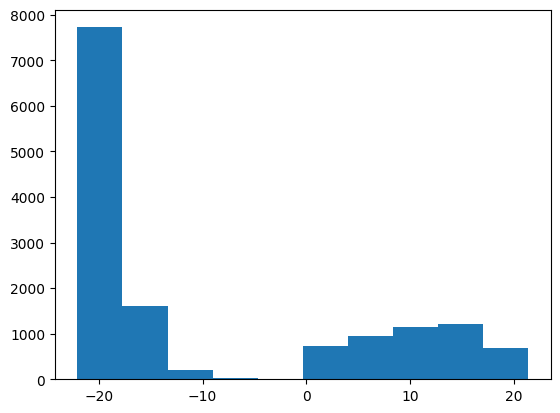

In [6]:
plt.hist(y)

> If y > 0 → The participant died within 15 years after the NHANES I examination. \
> If y < 0 → The participant was still alive 15 years after their examination. \
> If y is NaN → The survival time is unknown (such participants are removed from the dataset).

#### **Usage**
This dataset can be used for:

- Binary classification (someone survived 15+ years or not?).
- Survival analysis (modeling the time until death using y as the event time).


#### **In their study they decided to model this problem as a Cox Proportional Hazards but we can choose to model it as a classification problem**

In [7]:
y_binary = 1- (y < 0).astype(int) ### 0 : still alive, 1: died
y_binary

array([0, 0, 0, ..., 0, 0, 0])

## **Check the performances on this dataset**

### **Train XGBoost**

In [61]:
## parameter distributions for random search
param_dist = {
    "learning_rate": np.logspace(-4, -1, 10),
    "n_estimators": np.arange(100, 500, 200),
    "max_depth": np.arange(2, 10),
    "subsample": np.linspace(0.4, 1.0, 7),
    "reg_lambda": np.linspace(0, 10, 6),
    "reg_alpha": np.linspace(0, 5, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6)
}

## init XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

## random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30,
                                   scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_strain, y_strain)

## best params for random search
best_params = random_search.best_params_
print("Best parameters from random search:", best_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[0]	validation_0-logloss:0.61079
[299]	validation_0-logloss:0.39531
Confusion Matrix:
 [[1632  190]
 [ 255  598]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1822
           1       0.76      0.70      0.73       853

    accuracy                           0.83      2675
   macro avg       0.81      0.80      0.80      2675
weighted avg       0.83      0.83      0.83      2675

ROC AUC Score: 0.8781
PR AUC Score: 0.7882


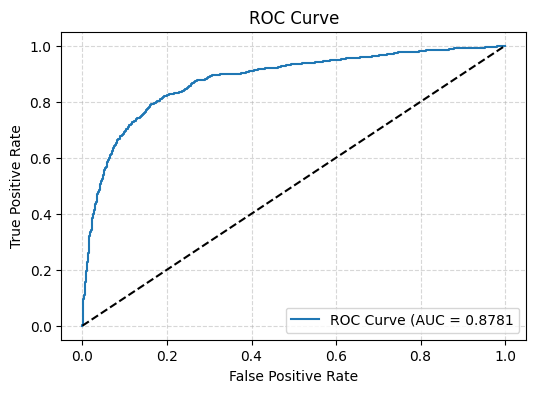

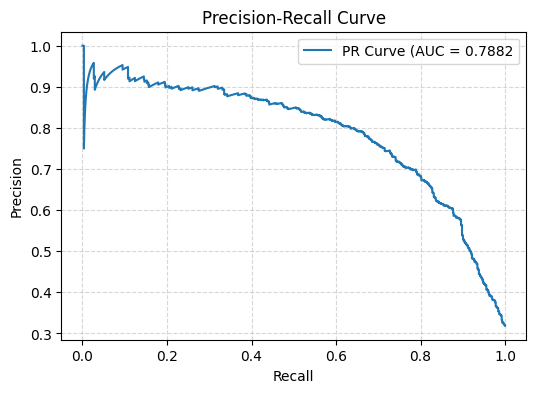

In [8]:
best_params= {'subsample': 0.5, 'reg_lambda': 8.0, 'reg_alpha': 5.0, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.046415888336127774, 'colsample_bytree': 0.9}

## Final model 
final_xgb = xgb.XGBClassifier(**best_params, objective='binary:logistic', n_jobs=-1, random_state=42)
final_xgb.fit(
    X_strain, y_strain, verbose=500,
    eval_set=[(X_valid, y_valid)])

y_pred = final_xgb.predict(X_valid)
y_pred_proba = final_xgb.predict_proba(X_valid)[:, 1]

## Metrics
conf_matrix = confusion_matrix(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)
pr_auc = average_precision_score(y_valid, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_valid, y_pred))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

## ROC Curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5, linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.5, linestyle='--')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### **Train Linear Model**

In [30]:
## Defining parameter distributions for random search for logistic regression
param_dist_logistic = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.logspace(-4, 4, 10),
    "solver": ["saga"],  # `saga` supports all penalty types
    "l1_ratio": np.linspace(0, 1, 10)  # Only used for elasticnet
}

## init Logistic Regression model
logistic_model = LogisticRegression(max_iter=10000, random_state=42, solver='saga', penalty='elasticnet')

## Perform random search
random_search_logistic = RandomizedSearchCV(logistic_model, param_distributions=param_dist_logistic, n_iter=30,
                                            scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search_logistic.fit(X_strain_imp, y_strain)

## Best params from random search
best_params_logistic = random_search_logistic.best_params_
print("Best parameters from random search for logistic regression:", best_params_logistic)


Confusion Matrix:
 [[1612  210]
 [ 254  599]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1822
           1       0.74      0.70      0.72       853

    accuracy                           0.83      2675
   macro avg       0.80      0.79      0.80      2675
weighted avg       0.82      0.83      0.83      2675

ROC AUC Score: 0.8730
PR AUC Score: 0.7802


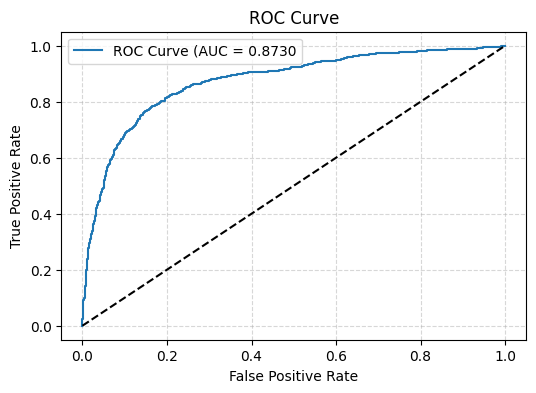

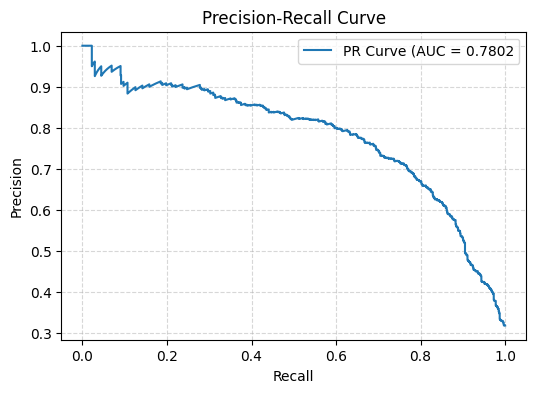

In [10]:
best_params_logistic = {'solver': 'saga',
               'penalty': 'elasticnet', 
               'l1_ratio': 0.7777777777777777, 
               'C': 0.046415888336127774}

final_logistic = LogisticRegression(**best_params_logistic, max_iter=10000, random_state=42)
final_logistic.fit(X_strain_imp, y_strain)

y_pred = final_logistic.predict(X_valid_imp)
y_pred_proba = final_logistic.predict_proba(X_valid_imp)[:, 1]

conf_matrix = confusion_matrix(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)
pr_auc = average_precision_score(y_valid, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_valid, y_pred))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

## Plots
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5, linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.5, linestyle='--')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# **TreeExplainer**
### **1) Bruteforce : Algorithm 1**

In [11]:
def EXPVALUE(x, S, tree):
    """
    Estimates E[f(x) | x_S] using Algorithm 1.
    :param x: Input sample (1D NumPy array)
    :param S: Set of selected features
    :param tree: Dictionary containing tree information
    :return: Expected value E[f(x) | x_S]
    """
    def G(j):
        # node in the dictionary ? 
        if j not in tree['v']:
            return 0.0  # default val
        
        # node is a leaf? ==> return its value
        if isinstance(tree['v'][j], (int, float)):
            return float(tree['v'][j])
        
        # node is internal? ==> ensure the feature index exists
        if j not in tree['d']:
            return 0.0  
        
        # feature index and threshold
        feature_index = tree['d'][j]
        threshold = float(tree['t'][j])
        left_child = tree['a'][j]
        right_child = tree['b'][j]
        
        # children exist in the dictionary?
        if left_child not in tree['r'] or right_child not in tree['r']:
            return 0.0 
        
        cover_left = float(tree['r'][left_child])
        cover_right = float(tree['r'][right_child])
        cover_total = float(tree['r'][j])
        
        # feature in S? ==> follow the decision path
        if feature_index in S:
            return G(left_child) if x[feature_index] <= threshold else G(right_child)
        else:
            return (G(left_child) * cover_left + G(right_child) * cover_right) / cover_total if cover_total > 0 else 0.0
    
    return G(0)  # Start at root node (assume it's indexed at 0)

def extract_tree_info(xgb_model, tree_index, feature_names):
    """
    Extracts tree structure from XGBoost model in a usable format.
    :param xgb_model: Trained XGBoost model
    :param tree_index: Index of the tree to extract
    :param feature_names: List of feature names in the dataset
    :return: Dictionary representing tree structure
    """
    booster = xgb_model.get_booster()
    dump = booster.get_dump(fmap="", with_stats=True)
    tree_str = dump[tree_index]
    
    tree = {'v': {}, 'a': {}, 'b': {}, 't': {}, 'r': {}, 'd': {}}
    
    for line in tree_str.split("\n"):
        if line.strip():
            parts = line.split("[")
            node_id = int(parts[0].split(":")[0])
            
            if len(parts) > 1 and "<" in parts[1]:  # Internal node
                condition = parts[1].split("]")[0]
                feature, threshold = condition.split("<")
                left_right = parts[1].split(",")
                left_child = int(left_right[0].split("=")[1])
                right_child = int(left_right[1].split("=")[1].split(" ")[0])
                cover = float(parts[1].split("cover=")[1])
                
                tree['v'][node_id] = "internal"
                
                # Convert feature name to index if needed
                if feature in feature_names:
                    tree['d'][node_id] = feature_names.index(feature)  # Find index in feature list
                elif feature.startswith("f") and feature[1:].isdigit():
                    tree['d'][node_id] = int(feature[1:])  # Convert "f0" to 0, "f1" to 1, etc.
                else:
                    raise ValueError(f"Unexpected feature format: {feature}")
                
                tree['t'][node_id] = float(threshold)
                tree['a'][node_id] = left_child
                tree['b'][node_id] = right_child
                tree['r'][node_id] = cover
                
                # Ensure children are initialized in the dictionary
                tree['v'].setdefault(left_child, "internal")
                tree['v'].setdefault(right_child, "internal")
                tree['r'].setdefault(left_child, 0.0)
                tree['r'].setdefault(right_child, 0.0)
            elif "leaf=" in parts[0]:  # Leaf node
                leaf_value = float(parts[0].split("leaf=")[1].split(",")[0])
                cover = float(parts[0].split("cover=")[1])
                
                tree['v'][node_id] = leaf_value
                tree['r'][node_id] = cover
    
    return tree

def compute_tree_shap(xgb_model, x, S, feature_names):
    """
    Compute the estimated E[f(x) | x_S] aggregated over all trees.
    :param xgb_model: Trained XGBoost model
    :param x: Input sample
    :param S: Set of features to condition on
    :param feature_names: List of feature names in the dataset
    :return: Sum of expected values E[f(x) | x_S] over all trees
    """
    num_trees = xgb_model.get_booster().num_boosted_rounds()
    total_shap_value = 0.0
    
    for tree_index in range(num_trees):
        tree = extract_tree_info(xgb_model, tree_index, feature_names)
        total_shap_value += EXPVALUE(x, S, tree)
    
    return total_shap_value

def compute_shap_for_dataset(xgb_model, X_train, S, nb_samples=None, precise_samples=None):
    """
    Compute the SHAP values for each sample in X_train.
    :param xgb_model: Trained XGBoost model
    :param X_train: Dataset (NumPy array or Pandas DataFrame)
    :param S: Set of features to condition on (list of feature names or indices)
    :return: SHAP values for all samples in X_train
    """
    feature_names = list(X_train.columns) if isinstance(X_train, pd.DataFrame) else None
    
    if isinstance(S, list) and feature_names is not None:
        S = set(feature_names.index(f) for f in S if f in feature_names)
    
    shap_values = []

    if precise_samples is not None:
        for i in tqdm(precise_samples):
            x = X_train.iloc[i].values
            shap_values.append(compute_tree_shap(xgb_model, x, S, feature_names))

    else: 
        if nb_samples is None: 
            for i in tqdm(range(len(X_train))):
                x = X_train.iloc[i].values
                shap_values.append(compute_tree_shap(xgb_model, x, S, feature_names))
        else:
            for i in tqdm(range(len(X_train.head(nb_samples)))):
                x = X_train.iloc[i].values
                shap_values.append(compute_tree_shap(xgb_model, x, S, feature_names))
    
    return np.array(shap_values)

In [12]:
def compute_tree_shap(xgb_model, x, S, feature_names):
    """
    Compute SHAP values for each feature in S, without aggregation.
    :param xgb_model: Trained XGBoost model
    :param x: Input sample
    :param S: Set of features to condition on
    :param feature_names: List of feature names in the dataset
    :return: SHAP values (vector of size |S|)
    """
    num_trees = xgb_model.get_booster().num_boosted_rounds()
    shap_values_per_feature = np.zeros(len(S))  # Stocke une valeur par feature

    for j, feature in enumerate(S):  # On calcule une SHAP value par feature
        total_shap_value = 0.0
        for tree_index in range(num_trees):
            tree = extract_tree_info(xgb_model, tree_index, feature_names)
            total_shap_value += EXPVALUE(x, {feature}, tree)  # Conditionner sur une seule feature
        shap_values_per_feature[j] = total_shap_value

    return shap_values_per_feature


def compute_shap_for_dataset(xgb_model, X_train, S, nb_samples=None, precise_samples=None):
    """
    Compute SHAP values per feature in S for all samples in X_train.
    :param xgb_model: Trained XGBoost model
    :param X_train: Dataset (NumPy array or Pandas DataFrame)
    :param S: Set of features to condition on (list of feature names or indices)
    :return: SHAP values matrix of shape (n_samples, |S|)
    """
    feature_names = list(X_train.columns) if isinstance(X_train, pd.DataFrame) else None
    
    if isinstance(S, list) and feature_names is not None:
        S = [feature_names.index(f) for f in S if f in feature_names]  # Convertir noms → indices

    shap_values = []

    if precise_samples is not None:
        for i in tqdm(precise_samples):
            x = X_train.iloc[i].values
            shap_values.append(compute_tree_shap(xgb_model, x, S, feature_names))
    else: 
        samples = X_train if nb_samples is None else X_train.head(nb_samples)
        for i in tqdm(range(len(samples))):
            x = samples.iloc[i].values
            shap_values.append(compute_tree_shap(xgb_model, x, S, feature_names))
    
    return np.array(shap_values)  # Retourne un tableau (n_samples, |S|)


In [13]:
X_train

,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isLarge,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,bmi
20751,False,51,3,NaN,85.0,False,False,NaN,True,False,...,False,False,NaN,False,6.2,False,False,110.0,40.0,25.406803
20753,False,41,2,NaN,68.0,False,False,2.27,False,False,...,False,False,NaN,False,7.7,False,False,136.0,54.0,24.588331
20754,True,31,2,NaN,61.0,False,False,1.86,False,False,...,False,False,NaN,False,4.9,False,False,110.0,24.0,23.756502
20756,True,29,3,NaN,37.0,False,False,1.69,False,False,...,False,False,NaN,False,4.3,False,False,98.0,36.0,19.216489
20759,True,36,2,NaN,35.0,False,False,NaN,True,False,...,False,False,NaN,False,4.3,False,False,108.0,40.0,23.102109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25038,True,54,3,NaN,48.0,False,False,2.35,False,False,...,False,False,NaN,False,4.0,False,False,102.0,27.0,24.390546
25043,True,63,2,NaN,86.0,False,False,2.24,False,False,...,False,False,NaN,False,7.2,False,False,150.0,65.0,35.425033
25046,True,56,2,NaN,65.0,False,False,2.31,False,False,...,False,False,NaN,False,5.1,False,False,98.0,38.0,22.069132
25049,True,47,2,NaN,46.0,False,False,1.93,False,False,...,False,False,NaN,False,3.2,False,False,108.0,28.0,17.915199


In [14]:
### specific example 
S_name = ["age","bmi"] 
S = set(X_train.columns.get_indexer(S_name))

shap_values = compute_shap_for_dataset(final_xgb, X_train, S, precise_samples=[1])
print(f"Shap values for {S_name[0]} for positive patient (those who died)")
print(shap_values) 
print("__________________")
shap_values = compute_shap_for_dataset(final_xgb, X_train, S, precise_samples=[5])
print(f"Shap values for {S_name[0]} for negative patient (those who survived)")
print(shap_values) 

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Shap values for age for positive patient (those who died)
[[-1.13386445 -0.16630492]]
__________________


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

Shap values for age for negative patient (those who survived)
[[ 0.53572743 -0.16982104]]


In [15]:
indices_1 = np.where(y_binary[:50] == 1)[0]
indices_0 = np.where(y_binary[:50] == 0)[0]

In [16]:
S_name = ["age","bmi"] 
S = set(X_train.columns.get_indexer(S_name))

shap_values = compute_shap_for_dataset(final_xgb, X, S, precise_samples=indices_1)
print(f"Shap values for {S_name[0]} for positive patients (those who died)")
print(shap_values) 
print("__________________")
shap_values = compute_shap_for_dataset(final_xgb, X, S, precise_samples=indices_0)
print(f"Shap values for {S_name[0]} for negative patients (those who survived)")
print(shap_values) 

100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


Shap values for age for positive patients (those who died)
[[-0.61491772  0.00626398]
 [-1.36839694 -0.02806209]
 [-0.58485381 -0.1767356 ]
 [ 0.73895578 -0.15897709]
 [ 0.53572743  0.11806194]
 [ 0.04977997 -0.01782541]
 [ 1.87788755  0.30755042]
 [-1.45305477  0.06914719]
 [-1.13386445 -0.1767356 ]]
__________________


100%|██████████| 41/41 [01:23<00:00,  2.04s/it]

Shap values for age for negative patients (those who survived)
[[-0.61491772 -0.16630492]
 [-1.13386445 -0.16630492]
 [-1.45305477 -0.16982104]
 [-0.73988065 -0.13904575]
 [-1.45403019  0.29070406]
 [-1.27012393 -0.13827209]
 [-0.73756359 -0.05329498]
 [ 0.53572743 -0.16982104]
 [-1.44849895  0.29070406]
 [-1.45305477 -0.1710257 ]
 [-1.45403019 -0.16630492]
 [-1.44849895  0.29070406]
 [-0.91767554 -0.17015472]
 [-1.27012393 -0.02806209]
 [-1.44849895  0.21175608]
 [-1.25734232 -0.17015472]
 [-1.27012393  0.11806194]
 [-0.61491772 -0.17015472]
 [ 1.22869182 -0.01782541]
 [-1.23233822 -0.13904575]
 [ 0.53572743 -0.16630492]
 [-0.91767554 -0.01332593]
 [ 1.22869182 -0.01782541]
 [-1.45403019 -0.1767356 ]
 [-1.45403019 -0.12788384]
 [-1.36839694  0.21175608]
 [-1.45403019 -0.15313231]
 [-1.45403019 -0.16982104]
 [-1.45403019  0.11806194]
 [-1.25734232 -0.15897709]
 [-0.91767554  0.11806194]
 [-1.45403019  0.29070406]
 [-0.20283951 -0.16139185]
 [-1.45305477 -0.05819066]
 [ 0.38740947 -0.17

### **Comparison with TreeExplainer implemented in the shap library**

In [17]:
explainer = shap.TreeExplainer(final_xgb)
xgb_shap = explainer.shap_values(X_train)

In [18]:
S_name = ["age","bmi"]
S = set(X_train.columns.get_indexer(S_name))

## SHAP Algo Bruteforce
shap_values_custom = compute_shap_for_dataset(final_xgb, X_train, S, nb_samples=10) 

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


In [19]:
## SHAP Algo Bruteforce values
shap_values_custom_selected = shap_values_custom
shap_values_custom_selected

array([[-0.61491772, -0.16630492],
       [-1.13386445, -0.16630492],
       [-1.45305477, -0.16982104],
       [-1.45403019,  0.29070406],
       [-1.27012393, -0.13827209],
       [ 0.53572743, -0.16982104],
       [-1.44849895,  0.29070406],
       [-1.45305477, -0.1710257 ],
       [-1.45403019, -0.16630492],
       [-1.44849895,  0.29070406]])

In [20]:
## SHAP Tree Explainer
explainer = shap.TreeExplainer(final_xgb)
shap_values_lib = explainer.shap_values(X_train.head(10))
shap_values_lib_selected = shap_values_lib[:10, X_train.columns.get_indexer(S_name)]
shap_values_lib_selected

array([[-0.5738057 , -0.14864402],
       [-1.1085588 , -0.15248375],
       [-1.5585097 , -0.13271458],
       [-1.5895098 ,  0.29458398],
       [-1.3846121 , -0.11960281],
       [ 0.82872385, -0.1429021 ],
       [-1.6207085 ,  0.27192235],
       [-1.7262067 , -0.1435157 ],
       [-1.7624886 , -0.12579645],
       [-1.6006309 ,  0.29179093]], dtype=float32)

In [21]:
## Compare results
diff = shap_values_lib_selected - shap_values_custom_selected

print(f"Differences between TreeExplainer SHAP and SHAP bruteforce:\n{diff}")

Differences between TreeExplainer SHAP and SHAP bruteforce:
[[ 0.04111203  0.0176609 ]
 [ 0.02530568  0.01382117]
 [-0.10545494  0.03710646]
 [-0.13547966  0.00387992]
 [-0.11448816  0.01866927]
 [ 0.29299642  0.02691893]
 [-0.17220951 -0.01878171]
 [-0.27315189  0.02751   ]
 [-0.30845841  0.04050846]
 [-0.15213193  0.00108688]]


# **Time complexity**
## **Time complexity of Bruteforce algorithm**

In [230]:
def time_bruteforce_per_tree(xgb_model, X_sample, max_features=70):
    """
    Mesure le temps d'exécution de l'algorithme brute-force en fonction du nombre de features.
    :param xgb_model: Modèle XGBoost entraîné
    :param X_sample: Échantillon de données (une seule instance)
    :param max_features: Nombre max de features à tester
    :return: Liste des temps d'exécution pour chaque M
    """
    times = []
    for M in range(1, max_features + 1,5):
        S = set(range(M))  # Prend les M premières features
        start_time = time.time()
        compute_shap_for_dataset(xgb_model, X_sample, S)
        end_time = time.time()
        times.append(end_time - start_time)
        print(f"M={M}, Time={times[-1]:.6f} sec")
    return times

In [231]:
M_max = 50  
X_sample = X_train.head(5)  # we set 10 samples

times = time_bruteforce_per_tree(final_xgb, X_sample, max_features=M_max)

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


M=1, Time=4.747552 sec


100%|██████████| 5/5 [00:33<00:00,  6.63s/it]


M=6, Time=33.142460 sec


100%|██████████| 5/5 [01:11<00:00, 14.37s/it]


M=11, Time=71.866615 sec


100%|██████████| 5/5 [01:46<00:00, 21.26s/it]


M=16, Time=106.292313 sec


100%|██████████| 5/5 [01:53<00:00, 22.70s/it]


M=21, Time=113.489461 sec


100%|██████████| 5/5 [02:32<00:00, 30.46s/it]


M=26, Time=152.303943 sec


100%|██████████| 5/5 [02:46<00:00, 33.33s/it]


M=31, Time=166.676971 sec


100%|██████████| 5/5 [03:03<00:00, 36.73s/it]


M=36, Time=183.636553 sec


100%|██████████| 5/5 [03:23<00:00, 40.73s/it]


M=41, Time=203.652787 sec


100%|██████████| 5/5 [03:44<00:00, 44.95s/it]

M=46, Time=224.741786 sec


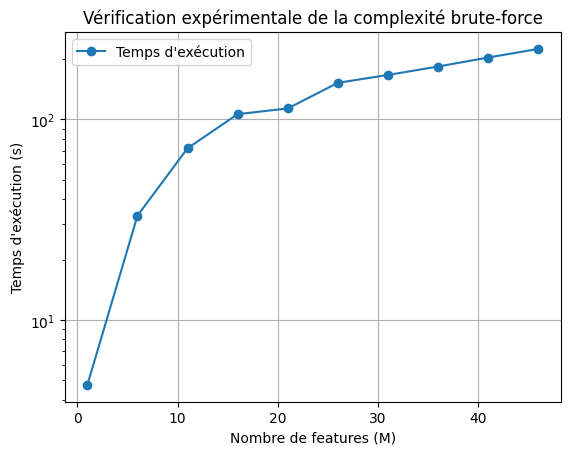

In [236]:
# Affichage des résultats
plt.plot(range(1, M_max + 1,5), times, marker='o', label="Temps d'exécution")
plt.yscale("log")  #
plt.xlabel("Nombre de features (M)")
plt.ylabel("Temps d'exécution (s)")
plt.title("Vérification expérimentale de la complexité brute-force")
plt.legend()
plt.grid()
plt.show()

## **Time complexity Tree SHAP**

In [163]:
def measure_treeshap_runtime(X, y, max_depth_list, T=100):
    """
    Mesure le temps d'exécution de TreeExplainer en fonction de la profondeur des arbres (D),
    avec un nombre d'arbres fixe (T).
    
    :param X: Dataset (features)
    :param y: Labels
    :param max_depth_list: Liste des valeurs de D (profondeur des arbres)
    :param T: Nombre fixe d'arbres
    :return: Résultats sous forme de dictionnaire {D: temps d'exécution}
    """
    results = {}
    
    for D in max_depth_list:
        print(f"Test avec D={D}...")

        best_params["max_depth"] = D

        model = xgb.XGBClassifier(**best_params)
        model.fit(X, y)

        explainer = shap.TreeExplainer(model)

        ## Time complexity measurement 
        start_time = time.time()
        shap_values = explainer.shap_values(X, check_additivity=False) 
        end_time = time.time()

        elapsed_time = end_time - start_time
        results[D] = elapsed_time
        print(f"Temps d'exécution : {elapsed_time:.4f} sec")

    return results


In [164]:
## Params
max_depth_list = [2, 4, 6, 8, 10, 20, 30, 40, 70]  
T_fixed = 100 

X_sample = X_train.iloc[:10000] 
y_sample = y_train[:10000]

results = measure_treeshap_runtime(X_sample, y_sample, max_depth_list, T=T_fixed)

Test avec D=2...
Temps d'exécution : 0.1990 sec
Test avec D=4...
Temps d'exécution : 0.9312 sec
Test avec D=6...
Temps d'exécution : 3.4982 sec
Test avec D=8...
Temps d'exécution : 9.5558 sec
Test avec D=10...
Temps d'exécution : 14.4795 sec
Test avec D=20...
Temps d'exécution : 27.9694 sec
Test avec D=30...
Temps d'exécution : 31.5757 sec
Test avec D=40...
Temps d'exécution : 33.9474 sec
Test avec D=50...
Temps d'exécution : 31.1269 sec
Test avec D=60...
Temps d'exécution : 31.9018 sec
Test avec D=70...
Temps d'exécution : 31.0893 sec
Test avec D=79...
Temps d'exécution : 31.8488 sec


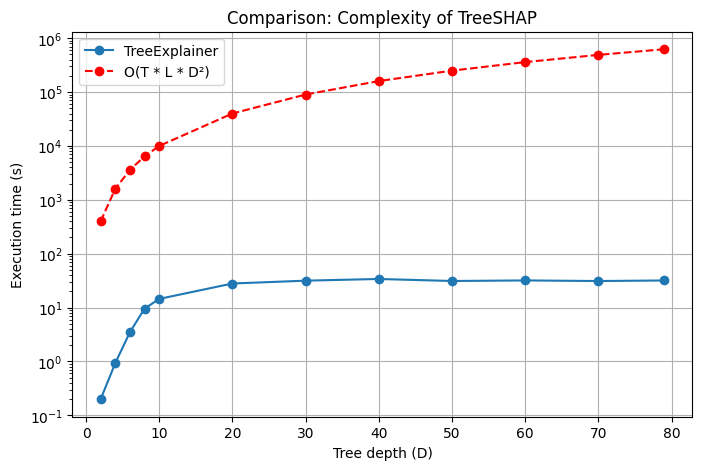

In [182]:
max_depth_list = np.array(max_depth_list)
T_fixed = 100 
L_fixed = np.array([2**x for x in max_depth_list]) # nb leaves estimated wrt D (approx. L = 2^D)
D_values = max_depth_list

## complexity : O(T * L * D^2)
theoretical_times = T_fixed * max_depth_list**2

## Plots
plt.figure(figsize=(8, 5))
plt.plot(max_depth_list, list(results.values()), marker="o", linestyle="-", label="TreeExplainer")
plt.plot(D_values, theoretical_times, marker="o", linestyle="--", color="r", label="O(T * L * D²)")
plt.xlabel("Tree depth (D)")
plt.ylabel("Execution time (s)")
plt.yscale("log")  # Log-scale for quadratic growth visualization
plt.title("Comparison: Complexity of TreeSHAP")
plt.legend()
plt.grid()
plt.show()


# **Dependence plots**

In [22]:
explainer = shap.TreeExplainer(final_xgb) 
shap_values_lib = explainer.shap_values(X)

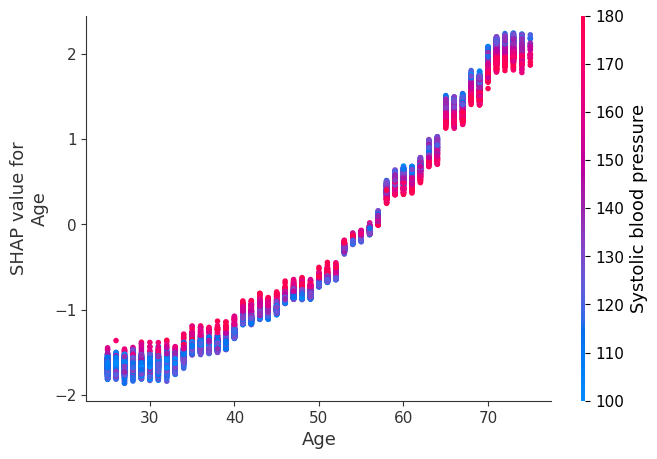

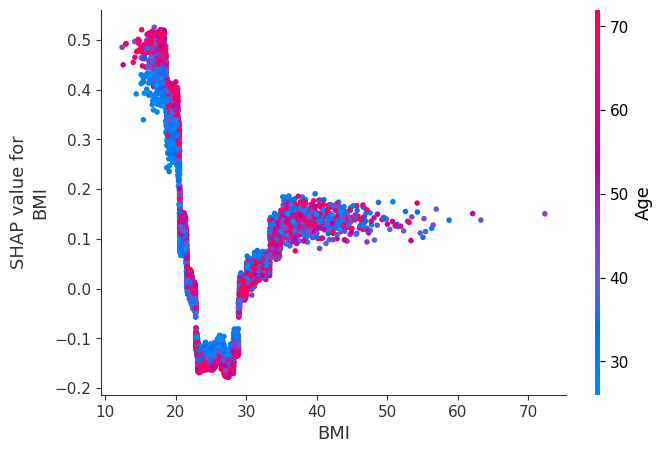

In [23]:
shap.dependence_plot(("Age"), shap_values_lib, X,feature_names=np.array(mapped_feature_names))
shap.dependence_plot(("BMI"), shap_values_lib, X,feature_names=np.array(mapped_feature_names))

# **Interaction effects**

In [24]:
xgb_shap_interaction = shap.TreeExplainer(final_xgb).shap_interaction_values(X)

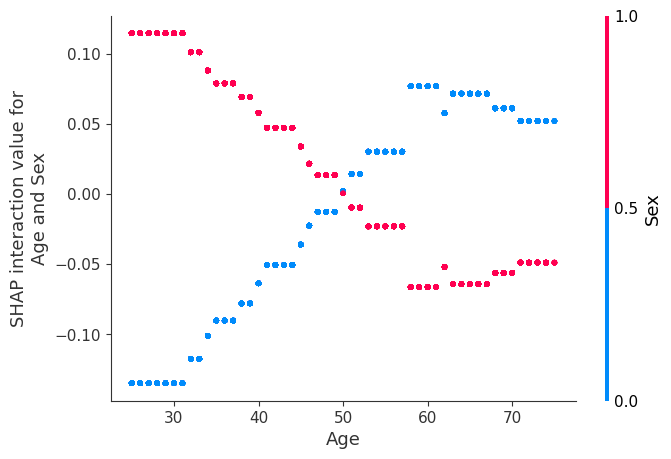

In [25]:
shap.dependence_plot(("Age", "Sex"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
plt.savefig("./figures/interactions_age_sex.png")
plt.show()

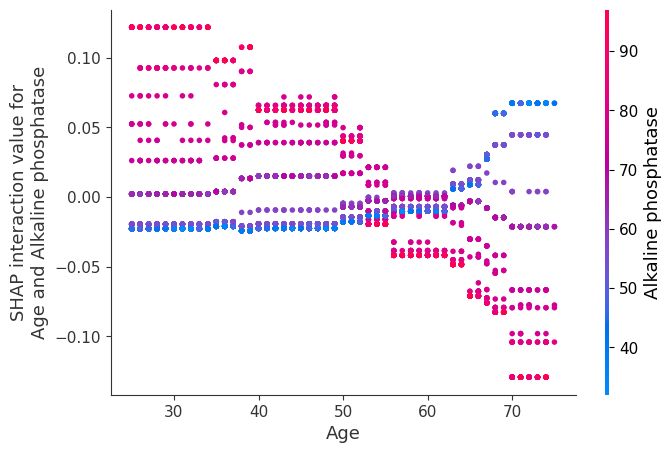

In [26]:
shap.dependence_plot(("Age","Alkaline phosphatase"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
plt.savefig("./figures/interactions_age_alkaline.png")
plt.show()

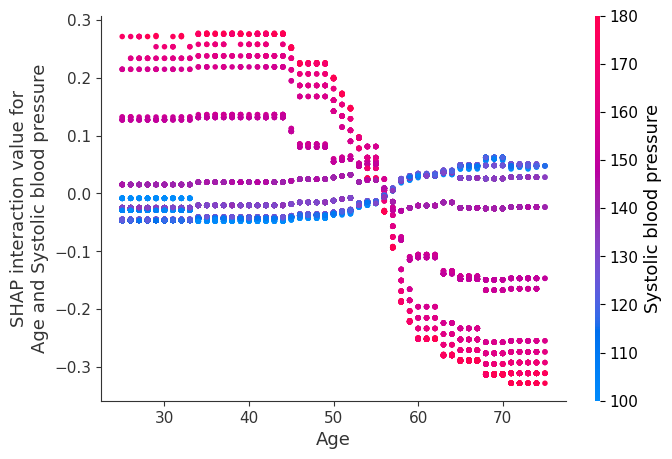

In [27]:
shap.dependence_plot(("Age", "Systolic blood pressure"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
plt.savefig("./figures/interactions_age_sbp.png")
plt.show()

# **From Local to Global**

In [28]:
## Compute feature importance with gain method
xgb_feature_importance = final_xgb.get_booster().get_score(importance_type="gain")
sorted_importance = sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True)

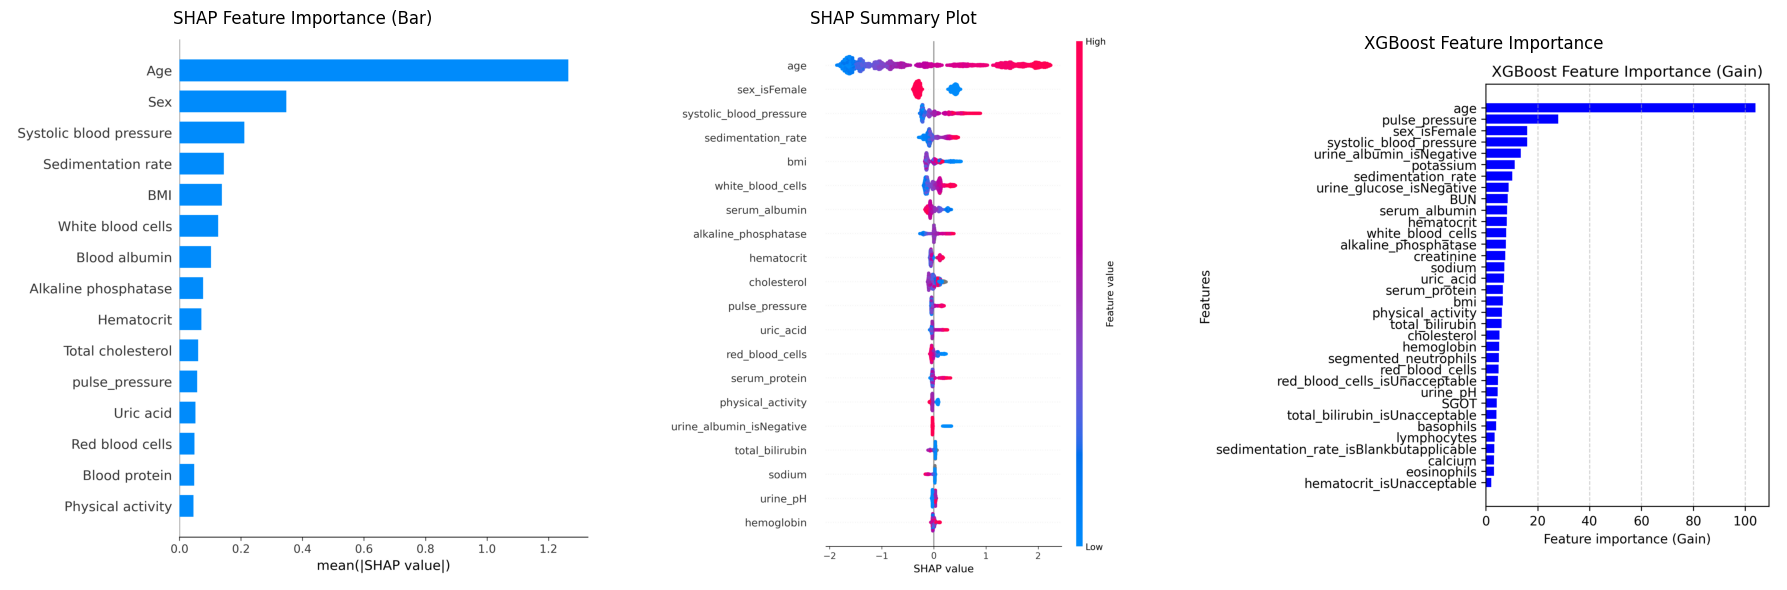

In [29]:

## Store figures 
shap_bar_plot_path = "./figures/shap_bar_plot.png"
shap_summary_plot_path = "./figures/shap_summary_plot.png"
xgb_importance_plot_path = "./figures/xgb_importance_plot.png"

## SHAP summary plot (bar)
plt.figure(figsize=(4, 6))
shap.summary_plot(
    shap_values_lib, X, feature_names=mapped_feature_names, plot_type="bar",
    max_display=15, show=False
)
plt.xlabel("mean(|SHAP value|)")
plt.savefig(shap_bar_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## SHAP summary plot (beeswarm)
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values_lib, X, show=False)
plt.xlabel("SHAP value")
plt.savefig(shap_summary_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## XGBoost Feature Importance plot
plt.figure(figsize=(4, 6))
plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance], color="blue")
plt.xlabel("Feature importance (Gain)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Gain)")
plt.gca().invert_yaxis()  # Mettre la feature la plus importante en haut
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.savefig(xgb_importance_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

shap_bar_img = plt.imread(shap_bar_plot_path)
shap_summary_img = plt.imread(shap_summary_plot_path)
xgb_importance_img = plt.imread(xgb_importance_plot_path)

axes[0].imshow(shap_bar_img)
axes[0].axis("off")
axes[0].set_title("SHAP Feature Importance (Bar)")

axes[1].imshow(shap_summary_img)
axes[1].axis("off")
axes[1].set_title("SHAP Summary Plot")

axes[2].imshow(xgb_importance_img)
axes[2].axis("off")
axes[2].set_title("XGBoost Feature Importance")

plt.tight_layout()
plt.show()
